In [1]:
import sys
sys.path.append('/accounts/grad/zhangyunzhe2023/tlide')

from typing import List, Optional
from llama import Dialog, Llama

import os
import math

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
import seaborn as sns

# choose any free port
os.environ.setdefault("MASTER_ADDR", "127.0.0.1")
os.environ.setdefault("MASTER_PORT", "29500")
os.environ.setdefault("RANK", "0")
os.environ.setdefault("WORLD_SIZE", "1")
os.environ.setdefault("LOCAL_RANK", "0")

# if you have a CUDA GPU, use 'nccl'; otherwise use 'gloo'
backend = "nccl" if torch.cuda.is_available() else "gloo"
if backend == "nccl":
    torch.cuda.set_device(0)

dist.init_process_group(backend=backend)

In [2]:
generator = Llama.build(
    ckpt_dir='/accounts/grad/zhangyunzhe2023/.llama/checkpoints/Llama3.2-1B',
    tokenizer_path='/accounts/grad/zhangyunzhe2023/.llama/checkpoints/Llama3.2-1B/tokenizer.model',
    max_seq_len=8192,
    max_batch_size=4,
)

tokenizer = generator.tokenizer
model = generator.model.eval()
params = generator.model.params

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1


/scratch/users/zhangyunzhe2023/conda/envs/torch28/lib/python3.13/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


Loaded in 3.74 seconds


In [3]:
from datasets import load_dataset
dataset = load_dataset('THUDM/LongBench-v2', split='train')

In [4]:
def get_tokens(text_id):
    text = dataset[text_id]['context']
    start = text.find('\n')
    text = text[start+1:]

    prompts: List[str] = [text]
    prompt_tokens = [tokenizer.encode(prompts[0], bos=True, eos=False)]
    tokens = torch.tensor(prompt_tokens, dtype=torch.long, device="cuda")
    return tokens

tokens = [get_tokens(i)[:, :8192] for i in range(4)]
tokens = torch.cat(tokens, dim=0)

In [5]:
_ = model.forward(tokens, 0, return_last_hidden=True)

In [6]:
del _

In [7]:
eval_layer = 7
eval_head = 0

cache_k = model.layers[eval_layer].attention.cache_k[:, :8193, eval_head]
cache_v = model.layers[eval_layer].attention.cache_v[:, :8193, eval_head]

In [8]:
def pairwise_cos_sim(x):
    x1 = x.unsqueeze(1)
    x2 = x.unsqueeze(0)
    cos_sim = nn.CosineSimilarity(dim=2, eps=1e-8)
    return cos_sim(x1, x2)

def pairwise_magnitude_sim(x):
    x_norm = torch.linalg.vector_norm(x, dim=1, keepdim=True)
    return -(x_norm - x_norm.T).abs()

In [9]:
k_cos_sim = [pairwise_cos_sim(cache_k[i]) for i in range(cache_k.size(0))]
k_cos_sim = torch.stack(k_cos_sim, dim=0).mean(dim=0).cpu().numpy()

In [10]:
k_mag_sim = [pairwise_magnitude_sim(cache_k[i]) for i in range(cache_k.size(0))]
k_mag_sim = torch.stack(k_mag_sim, dim=0).mean(dim=0).cpu().numpy()

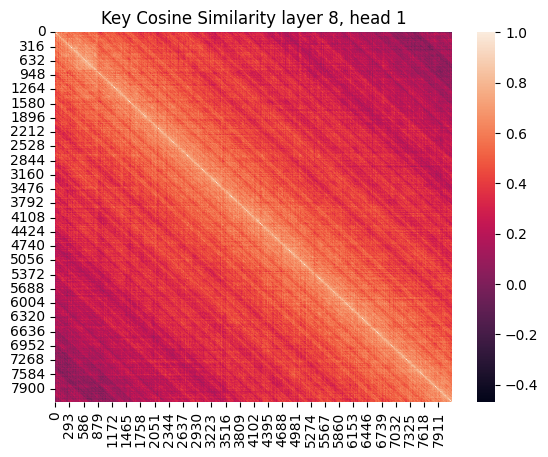

In [ ]:
import matplotlib.pyplot as plt
sns.heatmap(k_cos_sim)
plt.title(f"Key Cosine Similarity layer {eval_layer+1}, head {eval_head+1}")
plt.savefig(f"key_cosine_similarity_layer_{eval_layer+1}_head_{eval_head+1}.png")

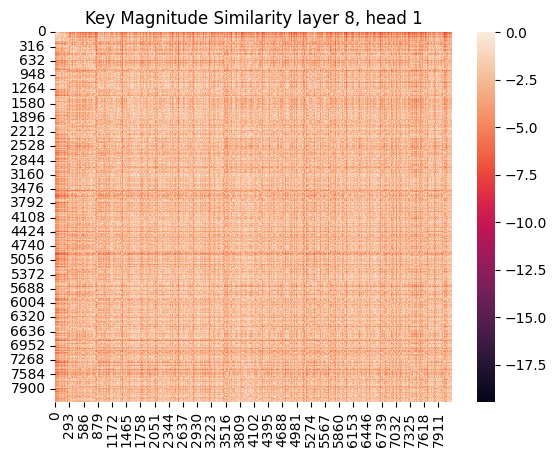

In [12]:
sns.heatmap(k_mag_sim)
plt.title(f"Key Magnitude Similarity layer {eval_layer+1}, head {eval_head+1}")
plt.savefig(f"key_magnitude_similarity_layer_{eval_layer+1}_head_{eval_head+1}.png")